# GraphCast: 基于图神经网络的全球中期天气预报

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindearth/zh_cn/medium-range/mindspore_graphcast.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindearth/zh_cn/medium-range/mindspore_graphcast.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_zh_cn/medium-range/graphcast.ipynb)

## 概述

GraphCast是由DeepMind和Google的研究人员开发的一个基于数据驱动的全球天气预报模型。它提供了关键全球天气指标的中期预报，分辨率为0.25°。相当于赤道附近约25公里x25公里的空间分辨率和大小为721 x 1440像素的全球网格。与以前的基于MachineLearning的天气预报模型相比，该模型将252个目标的准确率提高到99.2%。

本教程介绍了GraphCast的研究背景和技术路径，并展示了如何通过MindSpore Earth训练和快速推理模型。更多信息参见[文章](https://arxiv.org/abs/2212.12794)。本教程中使用分辨率为1.4°的部分数据集，结果如下所示。

## GraphCast

为了实现高分辨率预测，GraphCast在“encode-process-decode”模型中使用GNN作为骨干网。基于GNN的网络体系结构专为复杂的输入物理动力学而设计，使用消息传递，允许在任何范围内进行任意空间交互模式。该模型使用多网格表示，允许在几个步骤内进行远程交互。

下图展示了GraphCast的网络架构

![GraphCast model](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindearth/docs/source_zh_cn/medium-range/images/GraphCast.jpg)

1. Input weather state：高分辨率经纬度压力级网格表示了图（a）中的地表变量（黄色层）和大气变量（蓝色层）

2. Predict the next state: GraphCast模型通过当前时间状态和上一个时间状态预测下一步天气状态。形式如下：

$$
\hat X^{t-1} = GraphCast(X^t, X^{t-1})
$$

3. Roll out a forecast：GraphCast迭代生成T步预测。格式如下：

$$
\hat X^{t+1:t+T} = (GraphCast(X^t, X^{t-1}), GraphCast(X^{t+1}, X^{t}), ..., GraphCast(\hat X^{t+T-1}, \hat X^{t+T-2}))
$$

4. Encoder-Processor-Decoder：GraphCast模型包括编码器层、处理器层和解码器层。

    在编码器层中，所有输入特征都使用多层感知器（MLP）嵌入到隐层空间中。该模型使用消息传递步骤将原始经纬度网格传输到多网格。

    在处理器层中，一个16层深度GNN，用于学习包含所有多网格边缘的多网格上的长程边缘。对于每个GNN层，相邻节点用于更新网格边缘。然后，它通过聚合连接该节点的所有边的信息来更新网格节点。然后，向更新的边和节点添加残留连接。

    在解码器层中，它将多网格信息映射回原始经纬度网格，该网格通过聚合信息将网格更新为网格边缘。然后，向更新的边和节点添加残留连接。

5. Simultaneous multi-mesh message-passing：GraphCast的关键是多网格表示。多网格是一组二十面体网格$M^R$。

## 技术路径

MindSpore Earth求解该问题的具体流程如下:

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型评估与可视化

训练和测试所用的数据集可以在: [graphcast/dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/WeatherBench_1.4_69/) 下载。

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from mindspore import set_seed, load_checkpoint, load_param_into_net, context, Model
from mindspore.amp import DynamicLossScaleManager

下述`src`可以在[graphcast/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/medium-range/graphcast/src)下载。

In [2]:
from mindearth.utils import load_yaml_config, create_logger, plt_global_field_data, make_dir
from mindearth.module import Trainer
from mindearth.data import Dataset, Era5Data
from mindearth.cell import GraphCastNet

from src import get_coe, GridMeshInfo
from src import EvaluateCallBack, LossNet, CustomWithLossCell, InferenceModule

In [3]:
set_seed(0)
np.random.seed(0)
random.seed(0)

模型涉及的参数、优化器、数据配置见[config](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/graphcast/configs/GraphCast_1.4.yaml)。

In [4]:
# set context for training: using graph mode for high performance training with Ascend acceleration
config = load_yaml_config("GraphCast_1.4.yaml")
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

## 创建数据集

在[dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/WeatherBench_1.4_69/)路径下，下载正则化参数、训练数据集验证数据集到 `./dataset`目录。

修改[GraphCast_1.4.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/graphcast/configs/GraphCast_1.4.yaml)配置文件中的`root_dir`参数，该参数设置了数据集的路径。

`./dataset`中的目录结构如下所示：

``` markdown
.
├── statistic
│   ├── mean.npy
│   ├── mean_s.npy
│   ├── std.npy
│   └── std_s.npy
├── train
│   └── 2015
├── train_static
│   └── 2015
├── train_surface
│   └── 2015
├── train_surface_static
│   └── 2015
├── valid
│   └── 2016
├── valid_static
│   └── 2016
├── valid_surface
│   └── 2016
├── valid_surface_static
│   └── 2016
```


## 模型构建

模型初始化包括：

1. 加载mesh和grid的信息。

2. 加载per-variable-level在各时间差下的逆方差。

In [5]:
config['data']['data_sink'] = True # 是否使用data sink特性
config['data']['h_size'], config['data']['w_size'] = 128, 256 # 纬度和经度方向上的网格点数

config['optimizer']['epochs'] = 100 # 训练轮数
config['optimizer']['initial_lr'] = 0.00025 # 初始学习率

config['summary']["eval_interval"] = 10 # 评估间隔
config['summary']['plt_key_info'] = False # 是否绘制关键信息图
config['summary']["summary_dir"] = './summary' # 设置模型checkpoint的存储路径
make_dir(os.path.join(config['summary']["summary_dir"], "image"))
logger = create_logger(os.path.join(os.path.abspath(config['summary']["summary_dir"]), "results.log"))

In [6]:
data_params = config.get("data")
model_params = config.get("model")
grid_mesh_info = GridMeshInfo(data_params)
model = GraphCastNet(vg_in_channels=data_params.get('feature_dims') * data_params.get('t_in'),
                     vg_out_channels=data_params.get('feature_dims'),
                     vm_in_channels=model_params.get('vm_in_channels'),
                     em_in_channels=model_params.get('em_in_channels'),
                     eg2m_in_channels=model_params.get('eg2m_in_channels'),
                     em2g_in_channels=model_params.get('em2g_in_channels'),
                     latent_dims=model_params.get('latent_dims'),
                     processing_steps=model_params.get('processing_steps'),
                     g2m_src_idx=grid_mesh_info.g2m_src_idx,
                     g2m_dst_idx=grid_mesh_info.g2m_dst_idx,
                     m2m_src_idx=grid_mesh_info.m2m_src_idx,
                     m2m_dst_idx=grid_mesh_info.m2m_dst_idx,
                     m2g_src_idx=grid_mesh_info.m2g_src_idx,
                     m2g_dst_idx=grid_mesh_info.m2g_dst_idx,
                     mesh_node_feats=grid_mesh_info.mesh_node_feats,
                     mesh_edge_feats=grid_mesh_info.mesh_edge_feats,
                     g2m_edge_feats=grid_mesh_info.g2m_edge_feats,
                     m2g_edge_feats=grid_mesh_info.m2g_edge_feats,
                     per_variable_level_mean=grid_mesh_info.sj_mean,
                     per_variable_level_std=grid_mesh_info.sj_std,
                     recompute=model_params.get('recompute', False))

## 损失函数

GraphCast在模型训练中使用自定义均方差。计算公式为：

![Loss function](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindearth/docs/source_zh_cn/medium-range/images/loss.png)

In [7]:
sj_std, wj, ai = get_coe(config)
loss_fn = LossNet(ai, wj, sj_std, config.get('data').get('feature_dims'))
loss_cell = CustomWithLossCell(backbone=model, loss_fn=loss_fn, data_params=config.get('data'))

## 模型训练

在本教程中，我们继承了`Trainer`并重写了`get_solver`成员函数来构建自定义损失函数，并重写了`get_callback`成员函数来在训练过程中对测试数据集执行推理。

MindSpore Earth提供训练和推理接口，使用1.8.1及之后的MindSpore训练网络。

In [8]:
class GraphCastTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super().__init__(config, model, loss_fn, logger)
        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.pred_cb = self.get_callback()
        self.solver = self.get_solver()

    def get_solver(self):
        loss_scale = DynamicLossScaleManager()
        solver = Model(network=self.loss_fn,
                       optimizer=self.optimizer,
                       loss_scale_manager=loss_scale,
                       amp_level=self.train_params.get('amp_level'),
                       )
        return solver

    def get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb


In [9]:
trainer = GraphCastTrainer(config, model, loss_cell, logger)
trainer.train()

2023-08-18 08:31:11,242 - pretrain.py[line:211] - INFO: steps_per_epoch: 403


epoch: 1 step: 403, loss is 0.003921998
Train epoch time: 77295.547 ms, per step time: 191.800 ms
epoch: 2 step: 403, loss is 0.003456553
Train epoch time: 48287.290 ms, per step time: 119.820 ms
epoch: 3 step: 403, loss is 0.0028922241
Train epoch time: 48298.168 ms, per step time: 119.847 ms
epoch: 4 step: 403, loss is 0.0028646633
Train epoch time: 48293.240 ms, per step time: 119.834 ms
epoch: 5 step: 403, loss is 0.00251652
Train epoch time: 48303.110 ms, per step time: 119.859 ms
epoch: 6 step: 403, loss is 0.0024913677
Train epoch time: 48301.862 ms, per step time: 119.856 ms
epoch: 7 step: 403, loss is 0.0023838188
Train epoch time: 48326.265 ms, per step time: 119.916 ms
epoch: 8 step: 403, loss is 0.0021626246
Train epoch time: 48325.142 ms, per step time: 119.914 ms
epoch: 9 step: 403, loss is 0.002123243
Train epoch time: 48321.305 ms, per step time: 119.904 ms
epoch: 10 step: 403, loss is 0.002461584
Train epoch time: 49511.084 ms, per step time: 122.856 ms


2023-08-18 08:39:45,287 - forecast.py[line:204] - INFO: ================================Start Evaluation================================
2023-08-18 08:40:41,617 - forecast.py[line:222] - INFO: test dataset size: 8
2023-08-18 08:40:41,621 - forecast.py[line:173] - INFO: t = 6 hour: 
2023-08-18 08:40:41,622 - forecast.py[line:183] - INFO:  RMSE of Z500: 99.63094225503905, T2m: 1.7807282244821678, T850: 1.1389199313716583, U10: 1.3300655484052706
2023-08-18 08:40:41,623 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9995030164718628, T2m: 0.9949086904525757, T850: 0.9965617656707764, U10: 0.9709641933441162
2023-08-18 08:40:41,624 - forecast.py[line:173] - INFO: t = 72 hour: 
2023-08-18 08:40:41,625 - forecast.py[line:183] - INFO:  RMSE of Z500: 846.2669541832905, T2m: 5.095069601461138, T850: 4.291456435667611, U10: 5.033789250954006
2023-08-18 08:40:41,627 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9656049013137817, T2m: 0.9600029587745667, T850: 0.9581822752952576, U10: 0.59237

......

epoch: 91 step: 403, loss is 0.00090005953
Train epoch time: 48299.581 ms, per step time: 119.850 ms
epoch: 92 step: 403, loss is 0.0009103894
Train epoch time: 48302.468 ms, per step time: 119.857 ms
epoch: 93 step: 403, loss is 0.00090527127
Train epoch time: 48296.220 ms, per step time: 119.842 ms
epoch: 94 step: 403, loss is 0.0009113429
Train epoch time: 48314.221 ms, per step time: 119.886 ms
epoch: 95 step: 403, loss is 0.0008906296
Train epoch time: 48332.578 ms, per step time: 119.932 ms
epoch: 96 step: 403, loss is 0.0009023069
Train epoch time: 48344.677 ms, per step time: 119.962 ms
epoch: 97 step: 403, loss is 0.00088527385
Train epoch time: 48319.437 ms, per step time: 119.899 ms
epoch: 98 step: 403, loss is 0.00087669905
Train epoch time: 48319.398 ms, per step time: 119.899 ms
epoch: 99 step: 403, loss is 0.00088527397
Train epoch time: 48305.233 ms, per step time: 119.864 ms
epoch: 100 step: 403, loss is 0.00093020557
Train epoch time: 49486.354 ms, per step time: 122.

2023-08-18 09:57:55,343 - forecast.py[line:204] - INFO: ================================Start Evaluation================================
2023-08-18 09:58:29,557 - forecast.py[line:222] - INFO: test dataset size: 8
2023-08-18 09:58:29,562 - forecast.py[line:173] - INFO: t = 6 hour: 
2023-08-18 09:58:29,563 - forecast.py[line:183] - INFO:  RMSE of Z500: 71.52867536392974, T2m: 1.1144296184615285, T850: 0.950450431058116, U10: 1.2159413055648252
2023-08-18 09:58:29,564 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9997411966323853, T2m: 0.9980063438415527, T850: 0.9975705146789551, U10: 0.9757701754570007
2023-08-18 09:58:29,566 - forecast.py[line:173] - INFO: t = 72 hour: 
2023-08-18 09:58:29,567 - forecast.py[line:183] - INFO:  RMSE of Z500: 564.955831718179, T2m: 3.2896556874900664, T850: 2.986913832820727, U10: 3.7879051445350314
2023-08-18 09:58:29,568 - forecast.py[line:184] - INFO:  ACC  of Z500: 0.9842368364334106, T2m: 0.9827487468719482, T850: 0.9765684008598328, U10: 0.77273

## 模型评估和可视化

完成训练后，我们使用第100个ckpt进行推理。下述展示了预测值、地表和它们之间的误差可视化。

In [12]:
params = load_checkpoint('./summary/ckpt/step_1/GraphCast-100_403.ckpt')
load_param_into_net(model, params)
inference_module = InferenceModule(model, config, logger)

In [13]:
data_params = config.get("data")
test_dataset_generator = Era5Data(data_params=data_params, run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False,
                       num_workers=data_params.get('num_workers'), shuffle=False)
test_dataset = test_dataset.create_dataset(data_params.get('batch_size'))
data = next(test_dataset.create_dict_iterator())
inputs = data['inputs']
labels = data['labels']

In [14]:
labels = labels[..., 0, :, :]
labels = labels.transpose(0, 2, 1)
labels = labels.reshape(labels.shape[0], labels.shape[1], data_params.get("h_size"), data_params.get("w_size")).asnumpy()

pred = inference_module.forecast(inputs)
pred = pred[0].transpose(1, 0)
pred = pred.reshape(pred.shape[0], data_params.get("h_size"), data_params.get("w_size")).asnumpy()
pred = np.expand_dims(pred, axis=0)

In [15]:
def plt_key_info_comparison(pred, label, root_dir):
    """ Visualize the comparison of forecast results """
    std = np.load(os.path.join(root_dir, 'statistic/std.npy'))
    mean = np.load(os.path.join(root_dir, 'statistic/mean.npy'))
    std_s = np.load(os.path.join(root_dir, 'statistic/std_s.npy'))
    mean_s = np.load(os.path.join(root_dir, 'statistic/mean_s.npy'))

    plt.figure(num='e_imshow', figsize=(100, 50))

    plt.subplot(4, 3, 1)
    plt_global_field_data(label, 'Z500', std, mean, 'Ground Truth')  # Z500
    plt.subplot(4, 3, 2)
    plt_global_field_data(pred, 'Z500', std, mean, 'Pred')  # Z500
    plt.subplot(4, 3, 3)
    plt_global_field_data(label - pred, 'Z500', std, mean, 'Error', is_error=True)  # Z500

    plt.subplot(4, 3, 4)
    plt_global_field_data(label, 'T850', std, mean, 'Ground Truth')  # T850
    plt.subplot(4, 3, 5)
    plt_global_field_data(pred, 'T850', std, mean, 'Pred')  # T850
    plt.subplot(4, 3, 6)
    plt_global_field_data(label - pred, 'T850', std, mean, 'Error', is_error=True)  # T850

    plt.subplot(4, 3, 7)
    plt_global_field_data(label, 'U10', std_s, mean_s, 'Ground Truth', is_surface=True)  # U10
    plt.subplot(4, 3, 8)
    plt_global_field_data(pred, 'U10', std_s, mean_s, 'Pred', is_surface=True)  # U10
    plt.subplot(4, 3, 9)
    plt_global_field_data(label - pred, 'U10', std_s, mean_s, 'Error', is_surface=True, is_error=True)  # U10

    plt.subplot(4, 3, 10)
    plt_global_field_data(label, 'T2M', std_s, mean_s, 'Ground Truth', is_surface=True)  # T2M
    plt.subplot(4, 3, 11)
    plt_global_field_data(pred, 'T2M', std_s, mean_s, 'Pred', is_surface=True)  # T2M
    plt.subplot(4, 3, 12)
    plt_global_field_data(label - pred, 'T2M', std_s, mean_s, 'Error', is_surface=True, is_error=True)  # T2M

    plt.savefig(f'key_info_comparison.png', bbox_inches='tight')
    plt.show()

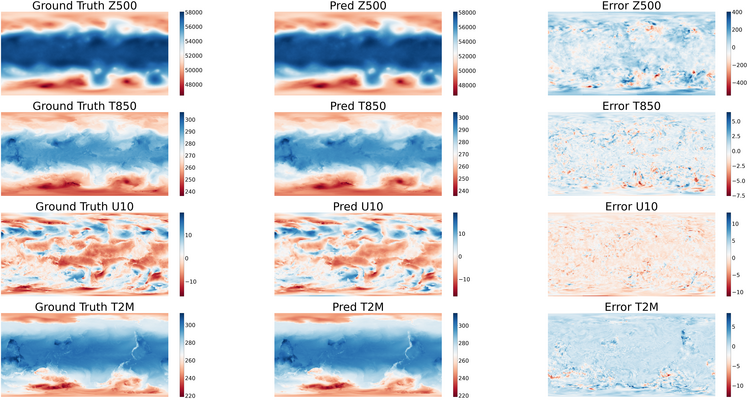

In [16]:
plt_key_info_comparison(pred, labels, data_params.get('root_dir'))